https://journals.ametsoc.org/view/journals/atot/27/3/2009jtecho725_1.xml

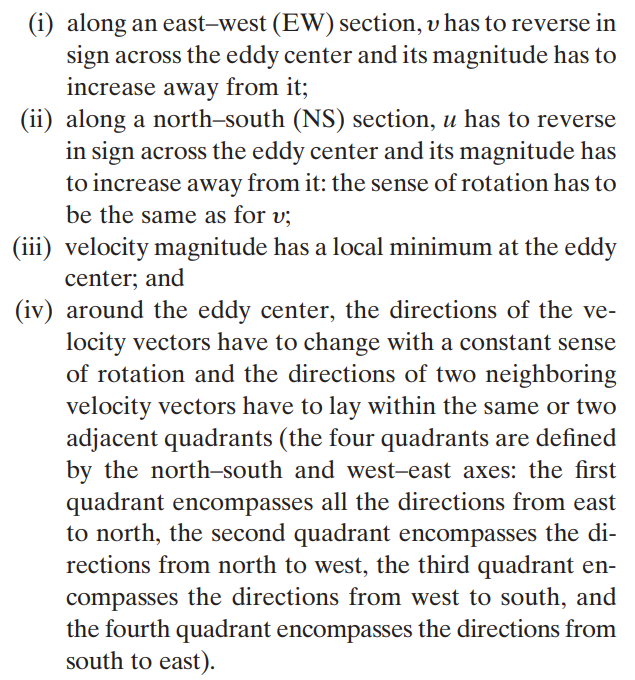

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

In [2]:
from scipy.io import netcdf_file
import os
# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
#dataset = 'data10102019'
dataset = "20042014"
f = netcdf_file(os.path.join(os.path.abspath('') ,f"{dataset}.nc"))
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_u = f.variables['ugos'].data.squeeze()
vel_v = f.variables['vgos'].data.squeeze()


# fill in missing values
from common_functions import interpolate_missing_point

#imputed_vel_u = interpolate_missing_point(vel_u, np.ma.masked_invalid(vel_u).mask)
#imputed_vel_v = interpolate_missing_point(vel_v, np.ma.masked_invalid(vel_v).mask)
imputed_vel_u = np.nan_to_num(vel_u, nan=1e30)
imputed_vel_v = np.nan_to_num(vel_v, nan=1e30)

In [3]:
f.variables['time'].data

array([23485.], dtype=float32)

## Method Parameters:

In [4]:
a = 2
b = 1

## Constaint 3 

<IPython.core.display.Javascript object>


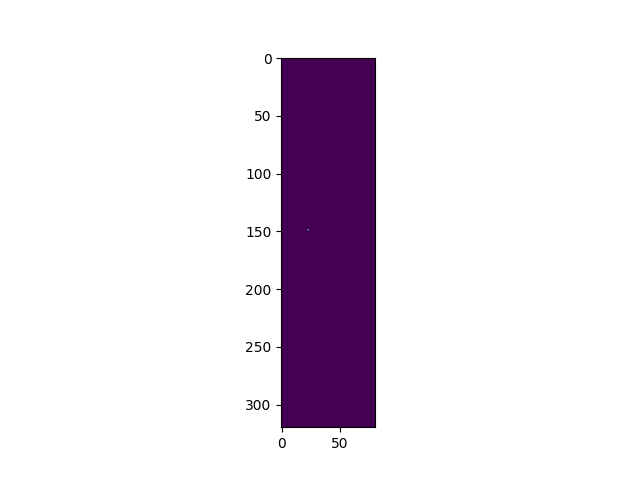

<IPython.core.display.Javascript object>


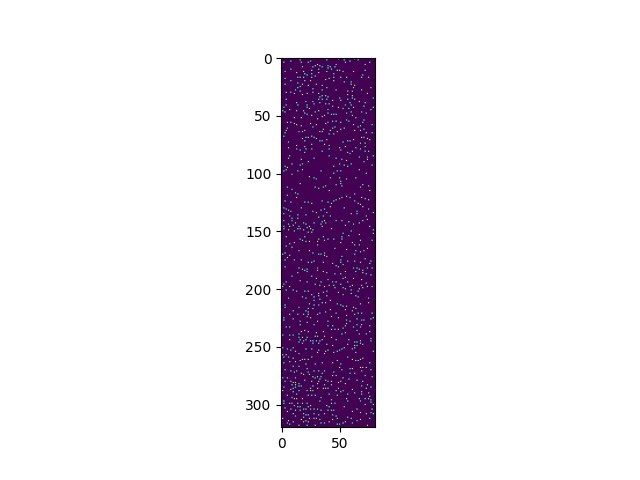

925


In [5]:
from skimage.feature import peak_local_max

vel_magnitude = np.hypot(imputed_vel_u, imputed_vel_v)
plt.figure()
plt.imshow(vel_magnitude)

satifies_crit_3 = peak_local_max(-vel_magnitude, min_distance=b)

plt.figure()
tmp = np.zeros_like(imputed_vel_u)
tmp[tuple(np.transpose(satifies_crit_3))] = 1
plt.imshow(tmp)
print(len(satifies_crit_3))

## Constraint 1

<IPython.core.display.Javascript object>


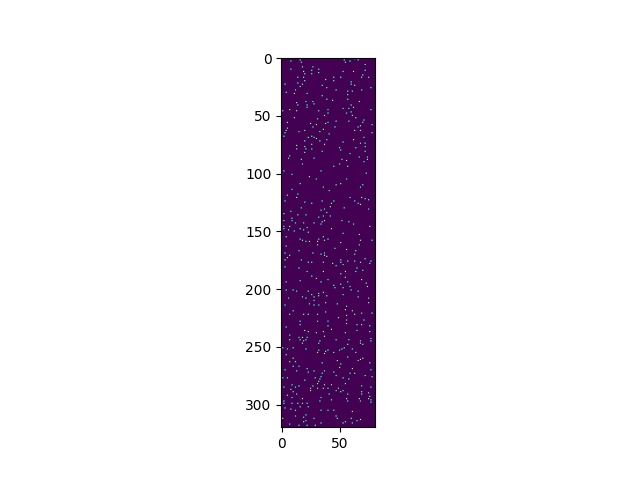

498


In [6]:
satifies_crit_1 = []
direction = []

for i,j in satifies_crit_3:
    center = imputed_vel_v[i,j]
    try:
        left = imputed_vel_v[i,j-a]
        right = imputed_vel_v[i,j+a]
    except IndexError:
        continue # point too close to the edge
    if abs(center) < abs(right) and abs(center) < abs(left) and np.sign(left)*np.sign(right) == -1:
        satifies_crit_1.append((i,j))
        direction.append(np.sign(left))

plt.figure()
tmp = np.zeros_like(imputed_vel_u)
tmp[tuple(np.transpose(satifies_crit_1))] = 1
plt.imshow(tmp)
print(len(satifies_crit_1))

## Constraint 2

<IPython.core.display.Javascript object>


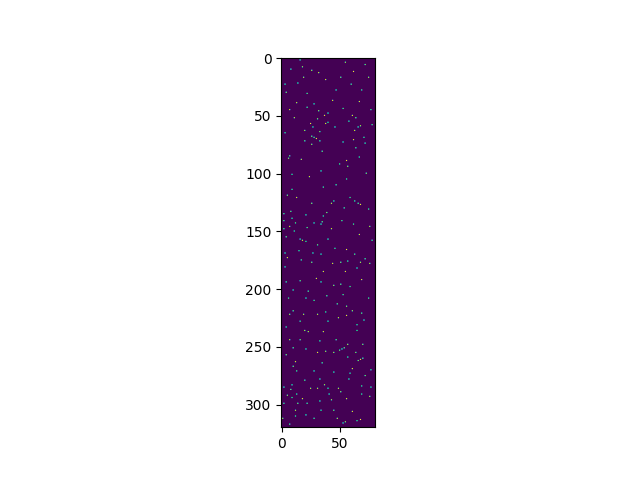

239


In [7]:
satifies_crit_2 = []

for (i, j), clockwise in zip(satifies_crit_1, direction):
    center = imputed_vel_u[i,j]
    try:
        bottom = imputed_vel_u[i-a, j]
        top = imputed_vel_u[i+a,j]
    except IndexError:
        continue # point to close to the edge
    if abs(center) < abs(bottom) and abs(center) < abs(top) and np.sign(bottom)*np.sign(top) == -1 and clockwise == np.sign(top):
        satifies_crit_2.append((i,j))

plt.figure()
tmp = np.zeros_like(imputed_vel_u)
tmp[tuple(np.transpose(satifies_crit_2))] = 1
plt.imshow(tmp)
print(len(satifies_crit_2))

## Constraint 4

In [8]:
satifies_crit_4 = []

get_edge = lambda arr: [arr[0,:-1], arr[:-1,-1], arr[-1,::-1], arr[-2:0:-1,0]]

extra_check = True

for i,j in satifies_crit_2:
    delta = a - 1
    try:
        area_u = imputed_vel_u[i-delta:i+delta,j-delta:j+delta]
        area_v = imputed_vel_v[i-delta:i+delta,j-delta:j+delta]
    except:
        continue
    edge_u = get_edge(area_u)
    edge_v = get_edge(area_v)
    
    if extra_check and not (np.unique(np.sign(edge_u[0])).size == 1 and 
        np.unique(np.sign(edge_u[2])).size == 1 and
        np.unique(np.sign(edge_v[1])).size == 1 and
        np.unique(np.sign(edge_v[3])).size == 1):
        continue
    
    edge_u = np.concatenate(edge_u)
    edge_v = np.concatenate(edge_v)
    v_angle = np.arctan2(edge_v, edge_u)
    v_angle[v_angle < 0] += 2*np.pi
    quadrant = np.zeros_like(v_angle)
    quadrant[(np.pi/2 <= v_angle) & (v_angle < np.pi)] = 1
    quadrant[(np.pi <= v_angle) & (v_angle < (3/2)*np.pi)] = 2
    quadrant[((3/2)*np.pi <= v_angle) & (v_angle < 2*np.pi)] = 3
    no_jumps = True
    for idx, q in enumerate(quadrant):
        if q == 0 and quadrant[(idx + 1) % len(quadrant)] in [0, 1, 3]:
            continue
        elif q == 1 and quadrant[(idx + 1) % len(quadrant)] in [1 , 0, 2]:
            continue
        elif q == 2 and quadrant[(idx + 1) % len(quadrant)] in [2, 1, 3]:
            continue
        elif q == 3 and quadrant[(idx + 1) % len(quadrant)] in [3 , 2, 0]:
            continue
        else:
            no_jumps = False
    satifies_crit_4.append((i,j))
print(len(satifies_crit_4))


0


## Plot the final thing

<IPython.core.display.Javascript object>


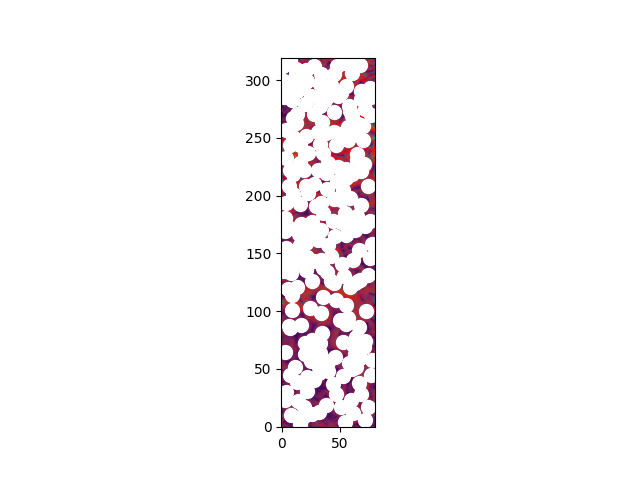

In [9]:
eddies = np.asarray(satifies_crit_2)

# start with magnitude of velocity as background
plt.figure()
plt.imshow(np.ma.masked_where(np.isnan(vel_u) & np.isnan(vel_v) ,vel_magnitude), origin='lower')
plt.quiver(np.ma.masked_where(np.isnan(vel_u) & np.isnan(vel_v) ,imputed_vel_u), np.ma.masked_where(np.isnan(vel_u) & np.isnan(vel_v) ,imputed_vel_v), color='r', scale=5)
plt.plot(eddies[:,1], eddies[:,0],'w.', markersize=20)

In [10]:
np.savetxt(f"vectorgeom-{dataset}.csv",np.column_stack([lat[eddies[:,0]], long[eddies[:,1]]]), delimiter=',')